# AirSourceHeatPump 모델 분석 노트북

이 노트북은 AirSourceHeatPump 모델의 성능을 분석하고 시각화합니다.


In [ ]:
%load_ext autoreload
%autoreload 2

# ===============================
# 1. Import 핵심 라이브러리 (우선순위: numerical/scientific/data)
import numpy as np           # 수치 해석용 (필수)
import pandas as pd          # 데이터프레임 처리용
import math                  # 수학 함수
from tqdm import tqdm        # 진행 상황 시각화
import matplotlib.pyplot as plt           # 플롯
import matplotlib.ticker as ticker        # 플롯 축 설정
import CoolProp.CoolProp as CP            # 열역학/물성치 구할 때 필요

# 2. 커스텀 라이브러리 (src 폴더 내)
import sys
sys.path.append('src')       # 커스텀 모듈 경로 추가

import dhw_ex_model as dem       # 모델 엔진 (src/dhw_ex_model)
import dartwork_mpl as dm        # 플롯 스타일 커스텀

# 3. 플롯 스타일 적용 (dartwork_mpl)
dm.use_style('dmpl_light')   # 다트워크 플롯 스타일 적용 (라이트)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 0. 준비


In [2]:
## Fontsize 지정
plt.rcParams['font.size'] = 9

fs = {
    'label': dm.fs(0),
    'tick': dm.fs(-1.0),
    'legend': dm.fs(-1.5),
    'subtitle': dm.fs(-0.5),
    'cbar_tick': dm.fs(-1.5),
    'cbar_label': dm.fs(-1.5),
    'cbar_title': dm.fs(-1),
    'setpoint': dm.fs(-1),
    'text': dm.fs(-2.0),
            }

pad = {
    'label': 6,
    'tick': 5,
}

LW = np.arange(0.25, 3.0, 0.25)


# 1. Constant


In [3]:
c_w = 4186  # J/kgK
rho_w = 1000  # kg/m3


# 2. 시뮬레이션 설정


## 2.1 ASHP 모델 정의


In [7]:
# AirSourceHeatPump 모델 객체 생성 (필요 인자만 전달, 클래스 정의 참고)
ashp_model = dem.AirSourceHeatPump(
    V_disp_cmp   = 0.0005,   # 압축기 토출 용적 [m3/rev]
    eta_cmp_isen = 0.7,      # 등엔트로피 효율
    A_iu         = 15.0,     # 실내측 열교환기 면적 [m2]
    A_ou         = 20.0,     # 실외측 열교환기 면적 [m2]
    A_cross_iu   = 0.3,      # 실내측 열교환기 관 통로 단면적 [m2]
    A_cross_ou   = 0.3,      # 실외측 열교환기 관 통로 단면적 [m2]
    U_iu        = 10.0,  # 실내기 열전달 특성 계수 [W/(m²·K)]
    U_ou        = 8.0,   # 실외기 열전달 특성 계수 [W/(m²·K)]
    T0           = 20        # 기준 온도 [°C] (20°C)
)

TypeError: AirSourceHeatPump.__init__() got an unexpected keyword argument 'U_iu'

## 2.2 시뮬레이션 시간 및 입력 데이터 생성


In [5]:
# 시뮬레이션 파라미터 설정
n_steps = 100  # 100 타임스텝
dt = 3600  # 1시간 간격 [초]
time = np.arange(0, n_steps * dt, dt)  # 시간 배열 [초]

# 실내 온도 패턴 생성 (일일 변동, 20-25°C 범위)
T_ia = [30] * n_steps

# 실외 온도 패턴 생성 (일일 변동, -5~15°C 범위, 겨울 시나리오)
# ⚠️ 주의: 난방 모드에서는 실외 온도가 실내 온도보다 낮아야 합니다!
# 실외 온도가 실내 온도보다 높으면 물리적으로 불가능한 상태가 발생합니다.
T_oa = [25] * n_steps  # 실외 온도를 실내 온도(20°C)보다 낮게 설정 (예: 5°C)

Q_iu_load = [1000] * n_steps


# 3. 시뮬레이션 실행


In [6]:
ashp_model.find_optimal_operation(
    Q_iu_load=100,
    T_ia=40,
    T_oa=25
)

NameError: name 'ashp_model' is not defined

# 5. 변풍량 팬 성능 분석: 설계 압력별 Part-load ratio 및 전력


## 5.1 설계 압력별 팬 성능 계산

변풍량 팬의 유량에 따라 설계 압력별 Part-load ratio와 전력을 계산합니다.


In [17]:
# 설계 압력별 팬 성능 분석
# ASHRAE 90.1 VSD Curve를 사용하여 변풍량 팬의 성능을 계산

# 팬 설계 파라미터 설정
fan_design_flow_rate = 2.0  # 설계 풍량 [m³/s] (고정)
fan_total_efficiency = 0.55  # 팬 전효율 [-] (고정)

# 설계 압력 범위 설정 [Pa]
fan_design_pressures = [300, 400, 500, 600, 700]

# 풍량 범위 설정: 0.1 ~ 설계 풍량의 1.2배
dV_range = np.linspace(0.1, fan_design_flow_rate * 1.0, 200)

# 결과 저장용 딕셔너리
fan_performance_by_pressure = {
    'dV_range': dV_range,
    'pressures': [],
    'flow_fractions': [],
    'pl_ratios': [],
    'fan_powers': [],
    'fan_design_powers': []
}

# 각 설계 압력에 대해 계산
for fan_design_pressure in fan_design_pressures:
    # 설계 전력 계산: P_design = (V_design * ΔP_design) / η_tot
    fan_design_power = (fan_design_flow_rate * fan_design_pressure) / fan_total_efficiency
    
    # 팬 파라미터 딕셔너리 생성
    fan_params = {
        'fan_design_flow_rate': fan_design_flow_rate,
        'fan_design_power': fan_design_power
    }
    
    # 각 풍량에 대해 Part-load ratio와 전력 계산
    flow_fractions = []
    pl_ratios = []
    fan_powers = []
    
    for dV_fan in dV_range:
        # ASHP 모델의 _calc_fan_power_from_airflow 메서드 사용
        result = ashp_model._calc_fan_power_from_airflow(dV_fan, fan_params)
        
        if result is not None:
            flow_fraction = dV_fan / fan_design_flow_rate
            fan_power = result['required_power_W']
            
            # Part-load ratio 계산: pl_ratio = fan_power / fan_design_power
            pl_ratio = fan_power / fan_design_power if fan_design_power > 0 else 0.0
            
            flow_fractions.append(flow_fraction)
            pl_ratios.append(pl_ratio)
            fan_powers.append(fan_power)
        else:
            flow_fractions.append(np.nan)
            pl_ratios.append(np.nan)
            fan_powers.append(np.nan)
    
    # 결과 저장
    fan_performance_by_pressure['pressures'].append(fan_design_pressure)
    fan_performance_by_pressure['flow_fractions'].append(np.array(flow_fractions))
    fan_performance_by_pressure['pl_ratios'].append(np.array(pl_ratios))
    fan_performance_by_pressure['fan_powers'].append(np.array(fan_powers))
    fan_performance_by_pressure['fan_design_powers'].append(fan_design_power)

print(f"팬 성능 계산 완료: {len(fan_design_pressures)} 개 설계 압력")


팬 성능 계산 완료: 5 개 설계 압력


## 5.2 설계 압력별 Part-load ratio 및 전력 그래프


In [45]:
# 설계 압력별 Part-load ratio 및 전력 그래프

# 색상 설정
colors = ['dm.blue5', 'dm.orange5', 'dm.green5', 'dm.red5', 'dm.violet5']

# 2행 1열 그래프 생성
fig, axes = plt.subplots(2, 1, figsize=(dm.cm2in(14), dm.cm2in(12)))

# 1. Part-load ratio vs Flow fraction
ax1 = axes[0]
for i, pressure in enumerate(fan_performance_by_pressure['pressures']):
    flow_fractions = fan_performance_by_pressure['flow_fractions'][i]
    pl_ratios = fan_performance_by_pressure['pl_ratios'][i]
    
    # NaN 제거
    mask = ~np.isnan(pl_ratios)
    if np.any(mask):
        ax1.plot(flow_fractions[mask], pl_ratios[mask], 
                color=colors[i % len(colors)], 
                linewidth=LW[2],
                label=f'ΔP_design = {pressure} Pa',
                alpha=0.8)

ax1.set_xlabel('Flow Fraction [-]', fontsize=fs['label'], labelpad=pad['label'])
ax1.set_ylabel('Part-load Ratio [-]', fontsize=fs['label'], labelpad=pad['label'])
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=fs['legend'], loc='best')
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax1.tick_params(axis='both', which='both', labelsize=fs['tick'], pad=pad['tick'])

# 2. Fan Power vs Flow fraction
ax2 = axes[1]
for i, pressure in enumerate(fan_performance_by_pressure['pressures']):
    flow_fractions = fan_performance_by_pressure['flow_fractions'][i]
    fan_powers = fan_performance_by_pressure['fan_powers'][i]
    
    # NaN 제거
    mask = ~np.isnan(fan_powers)
    if np.any(mask):
        ax2.plot(flow_fractions[mask], fan_powers[mask], 
                color=colors[i % len(colors)], 
                linewidth=LW[2],
                label=f'ΔP_design = {pressure} Pa',
                alpha=0.8)

ax2.set_xlabel('Flow Fraction [-]', fontsize=fs['label'], labelpad=pad['label'])
ax2.set_ylabel('Fan Power [W]', fontsize=fs['label'], labelpad=pad['label'])

ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=fs['legend'], loc='best')
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax2.tick_params(axis='both', which='both', labelsize=fs['tick'], pad=pad['tick'])

plt.tight_layout()
dm.simple_layout(fig, margins=(0.05, 0.05, 0.05, 0.05), bbox=[0, 1, 0.02, 1])
plt.savefig('figure/ASHP/fan_performance_by_design_pressure.png', dpi=300)
dm.save_and_show(fig)
plt.close()

print("설계 압력별 팬 성능 그래프 생성 완료")


설계 압력별 팬 성능 그래프 생성 완료


## 5.3 설계 압력별 정규화된 전력 그래프

설계 전력으로 정규화하여 설계 압력에 관계없이 Part-load 특성을 비교합니다.


In [42]:
# 설계 압력별 정규화된 전력 그래프

fig, ax = plt.subplots(1, 1, figsize=(dm.cm2in(14), dm.cm2in(6)))

colors = ['dm.blue5', 'dm.orange5', 'dm.green5', 'dm.red5', 'dm.violet5']

for i, pressure in enumerate(fan_performance_by_pressure['pressures']):
    flow_fractions = fan_performance_by_pressure['flow_fractions'][i]
    fan_powers = fan_performance_by_pressure['fan_powers'][i]
    fan_design_power = fan_performance_by_pressure['fan_design_powers'][i]
    
    # 정규화된 전력 계산
    normalized_powers = fan_powers / fan_design_power if fan_design_power > 0 else np.zeros_like(fan_powers)
    
    # NaN 제거
    mask = ~np.isnan(normalized_powers)
    if np.any(mask):
        ax.plot(flow_fractions[mask], normalized_powers[mask], 
                color=colors[i % len(colors)], 
                linewidth=LW[2],
                label=f'ΔP_design = {pressure} Pa',
                alpha=0.8)

ax.set_xlabel('Flow Fraction [-]', fontsize=fs['label'], labelpad=pad['label'])
ax.set_ylabel('Normalized Fan Power [-]', fontsize=fs['label'], labelpad=pad['label'])

ax.grid(True, alpha=0.3)
ax.legend(fontsize=fs['legend'], loc='best')
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.tick_params(axis='both', which='both', labelsize=fs['tick'], pad=pad['tick'])

dm.simple_layout(fig, margins=(0.05, 0.05, 0.05, 0.05), bbox=[0, 1, 0.02, 1])
plt.savefig('figure/ASHP/fan_normalized_power_by_design_pressure.png', dpi=300)
dm.save_and_show(fig)
plt.close()

print("정규화된 전력 그래프 생성 완료")


정규화된 전력 그래프 생성 완료


In [ ]:
# 시뮬레이션 결과 저장용 리스트
results_data = []

# 각 타임스텝마다 최적 운전점 탐색
for i in tqdm(range(n_steps), desc="ASHP Simulating"):
    result = ashp_model.find_optimal_operation(
        Q_iu_load=Q_iu_load[i],
        T_ia=T_ia[i],
        T_oa=T_oa[i]
    )
    print(result)
    
    # 결과 딕셔너리에 시간 정보 추가 (time은 result에 없으므로 추가)
    # T_ia, T_oa, Q_iu_load는 이미 result에 포함되어 있음
    # result['time'] = time[i]
    
    # 모든 데이터를 결과 리스트에 추가
    # result 딕셔너리에는 다음 항목들이 모두 포함됨:
    # - is_on, mode
    # - 열량: Q_ref_cond, Q_ref_evap, Q_iu_load
    # - 전력: E_cmp, E_iu_fan, E_ou_fan, E_tot, cop
    # - 압축기: cmp_rps, cmp_rpm
    # - 팬: fan_result_iu, fan_result_ou
    # - 유량: m_dot_ref, dV_iu_fan, dV_ou_fan
    # - 온도: T_ia, T_oa, T_cond, T_evap, T1, T2, T3, T4
    # - 압력: P1, P2, P3, P4
    # - 엔탈피: h1, h2, h3, h4
    # - 엔트로피: s1, s2, s3, s4
    # - 엑서지: x1, x2, x3, x4
    results_data.append(result)

# DataFrame으로 변환
df = pd.DataFrame(results_data)

# CSV 저장 (선택적)
df.to_csv('result/ashp_simulation_results.csv', index=False)
print(f"시뮬레이션 완료: {len(results_data)} 타임스텝")
print(f"데이터 저장 완료: result/ashp_simulation_results.csv")

# 4. 데이터 분석 및 시각화


## 4.1 데이터 시리즈 추출


In [7]:
# 기본 데이터 추출
is_on = df['is_on'].to_numpy()
mode = df['mode'].to_numpy()

# 열량 데이터
Q_ref_cond = df['Q_ref_cond'].to_numpy()
Q_ref_evap = df['Q_ref_evap'].to_numpy()
Q_iu_load = df['Q_iu_load'].to_numpy()

# 전력 데이터
E_cmp = df['E_cmp'].to_numpy()
E_iu_fan = df['E_iu_fan'].to_numpy()
E_ou_fan = df['E_ou_fan'].to_numpy()
E_tot = df['E_tot'].to_numpy()

# COP
cop = df['cop'].to_numpy()

# 유량 데이터
m_dot_ref = df['m_dot_ref'].to_numpy()
dV_iu_fan = df['dV_iu_fan'].to_numpy()
dV_ou_fan = df['dV_ou_fan'].to_numpy()
cmp_rpm = df['cmp_rpm'].to_numpy()

# 온도 데이터
T_ia = df['T_ia'].to_numpy()
T_oa = df['T_oa'].to_numpy()
T_cond = df['T_cond'].to_numpy()
T_evap = df['T_evap'].to_numpy()
T1 = df['T1'].to_numpy()
T2 = df['T2'].to_numpy()
T3 = df['T3'].to_numpy()
T4 = df['T4'].to_numpy()

# 압력 데이터
P1 = df['P1'].to_numpy()
P2 = df['P2'].to_numpy()
P3 = df['P3'].to_numpy()
P4 = df['P4'].to_numpy()

# 엔탈피 데이터
h1 = df['h1'].to_numpy()
h2 = df['h2'].to_numpy()
h3 = df['h3'].to_numpy()
h4 = df['h4'].to_numpy()


NameError: name 'df' is not defined

## 4.2 플롯 함수 정의


In [8]:
def plot_simple_graph(df_column, time, xlabel, ylabel, xmin=0, xmax=24, Kelvin=False, color='dm.blue5', savepath=None):
    """단일 데이터 시리즈를 플로팅하는 함수"""
    if Kelvin:
        y = dem.K2C(df_column)
    else:
        y = df_column
    x = time * dem.s2h  # 초를 시간으로 변환

    fig, ax = plt.subplots(figsize=(dm.cm2in(16), dm.cm2in(6)))
    
    # 마이너 틱 설정
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))

    ax.plot(x, y, color=color, linewidth=LW[2])
    ax.set_xlim(xmin, xmax)
    if xmax % 24 == 0: 
        if xmax == 24:
            ax.set_xticks(np.arange(0, 25, 2))
        elif xmax == 48:
            ax.set_xticks(np.arange(0, xmax+1, 6))
        elif xmax == 72:
            ax.set_xticks(np.arange(0, xmax+1, 12))
        elif xmax > 72:
            ax.set_xticks(np.arange(0, xmax+1, 24))

    ax.tick_params(axis='both', which='both', labelsize=fs['tick'], pad=pad['tick'])
    ax.set_ylim(np.nanmin(y)*0.9, np.nanmax(y)*1.1)
    ax.set_xlabel(xlabel, fontsize=fs['label'], labelpad=pad['label'])
    ax.set_ylabel(ylabel, fontsize=fs['label'], labelpad=pad['label'])
    dm.simple_layout(fig, margins=(0.05, 0.05, 0.05, 0.05), bbox=[0, 1, 0.02, 1])
    if savepath:
        plt.savefig(f'{savepath}.png')
    dm.save_and_show(fig)
    plt.close()

def plot_multi_graph(df_columns, legends, time, xlabel, ylabel, linestyles=None, colors=None, xmin=0, xmax=24, Kelvin=False, savepath=None, scatter=False):
    """여러 데이터 시리즈를 하나의 그래프에 플로팅하는 함수"""
    if len(df_columns) != len(legends):
        raise ValueError("데이터 컬럼의 개수와 레이블의 개수가 일치해야 합니다.")

    fig, ax = plt.subplots(figsize=(dm.cm2in(16), dm.cm2in(6)))
    x = time * dem.s2h
    
    if colors is None:
        colors = ['dm.blue5', 'dm.orange5', 'dm.green5', 'dm.red5', 'dm.violet5',
                  'dm.gray5', 'dm.yellow5', 'dm.cyan5']
    
    global_min = np.inf
    global_max = -np.inf
    
    processed_ys = []
    for col in df_columns:
        y = dem.K2C(col) if Kelvin else col
        processed_ys.append(y)
        if len(y) > 0:
            global_min = min(global_min, np.nanmin(y))
            global_max = max(global_max, np.nanmax(y))
    
    for i, y_data in enumerate(processed_ys):
        current_color = colors[i % len(colors)]
        current_label = legends[i]

        if scatter:
            ax.scatter(x, y_data, color=current_color, label=current_label, s=1.5, alpha=0.3)
        else:
            current_linestyle = linestyles[i % len(linestyles)] if linestyles is not None else ['-', '--', '-.', ':'][i % 4]
            ax.plot(x, y_data, color=current_color, linewidth=LW[1], label=current_label, linestyle=current_linestyle)

    ax.set_xlim(xmin, xmax)
    if xmax % 24 == 0: 
        if xmax == 24:
            ax.set_xticks(np.arange(0, 25, 2))
        elif xmax == 48:
            ax.set_xticks(np.arange(0, xmax+1, 6))
        elif xmax == 72:
            ax.set_xticks(np.arange(0, xmax+1, 12))
        elif xmax > 72:
            ax.set_xticks(np.arange(0, xmax+1, 24))
    
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    
    ax.tick_params(axis='both', which='both', labelsize=fs['tick'], pad=pad['tick'])
    global_int = global_max - global_min
    
    if np.isinf(global_min) or np.isinf(global_max):
        ax.set_ylim(0, 1)
    else:
        ax.set_ylim(global_min - global_int * 0.3, global_max + global_int * 0.3)
    
    ax.set_xlabel(xlabel, fontsize=fs['label'], labelpad=pad['label'])
    ax.set_ylabel(ylabel, fontsize=fs['label'], labelpad=pad['label'])

    ax.legend(ncol=min(6, len(legends)), fontsize=fs['legend'])
    dm.simple_layout(fig, margins=(0.05, 0.05, 0.05, 0.05), bbox=[0, 1, 0.02, 1])
    
    if savepath:
        plt.savefig(f'{savepath}.png')
        
    dm.save_and_show(fig)
    plt.close()


In [9]:
# 실내/실외 온도 및 사이클 온도
plot_multi_graph(
    df_columns=[
        T_ia,
        T_oa,
        T_cond,
        T_evap,
    ],
    legends=[
        'Indoor air temp [°C]',
        'Outdoor air temp [°C]',
        'Condensing temp [°C]',
        'Evaporating temp [°C]',
    ],
    time=time,
    xlabel='Time [hours]',
    ylabel='Temperature [°C]',
    xmin=0,
    xmax=100,
    colors=['dm.blue5', 'dm.red5', 'dm.orange5', 'dm.green5'],
    savepath='figure/ASHP/temperatures'
)


NameError: name 'T_cond' is not defined

In [10]:
# 사이클 상태점 온도
plot_multi_graph(
    df_columns=[
        T1,
        T2,
        T3,
        T4,
    ],
    legends=[
        'State 1 temp [°C]',
        'State 2 temp [°C]',
        'State 3 temp [°C]',
        'State 4 temp [°C]',
    ],
    time=time,
    xlabel='Time [hours]',
    ylabel='Temperature [°C]',
    xmin=0,
    xmax=100,
    colors=['dm.blue5', 'dm.red5', 'dm.orange5', 'dm.green5'],
    savepath='figure/ASHP/cycle_temperatures'
)


NameError: name 'T1' is not defined

# 5. 팬 성능 검증


In [11]:

## 5.1 팬 성능 계산: 유속에 따른 효율, 압력, 전력 변화

# 팬 파라미터 설정 (실내기 팬 기준)
P_max = 500.0  # 최대 정압 [Pa]
dV_max = 2.0   # 최대 풍량 [m³/s]
eta_max = 0.7  # 최대 효율 [-]
bep_ratio = 0.75  # 최고 효율점 비율 [-] 최대 풍량의 75% 지점
A_fan = 0.5    # 팬 토출 면적 [m²]

# k_sys 값 리스트 (저항계수) [Pa/(m³/s)²]
k_sys_list = [50, 96, 125, 200]

# 유속 범위 설정
dV_range = np.linspace(0.1, dV_max, 100)  # 0.1 ~ 2.0 m³/s

# 결과 저장용 딕셔너리
fan_performance_data = {
    'dV_fan': dV_range,
    'k_sys': [],
    'efficiency': [],
    'pressure': [],
    'power': []
}

# 각 k_sys 값에 대해 계산
for k_sys in k_sys_list:
    # 팬 파라미터 딕셔너리 생성
    fan_params = {
        'P_max': P_max,
        'dV_max': dV_max,
        'eta_max': eta_max,
        'k_sys': k_sys,
        'A_fan': A_fan,
        'bep_ratio': bep_ratio
    }
    
    # 각 유속에 대해 성능 계산
    efficiencies = []
    pressures = []
    powers = []
    
    for dV in dV_range:
        # _calc_fan_power_from_airflow 메서드 호출
        result = ashp_model._calc_fan_power_from_airflow(dV, fan_params)
        
        if result is not None:
            efficiencies.append(result['operating_efficiency'])
            pressures.append(result['operating_pressure_Pa'])
            powers.append(result['required_power_W'])
        else:
            efficiencies.append(np.nan)
            pressures.append(np.nan)
            powers.append(np.nan)
    
    # 결과 저장
    fan_performance_data['k_sys'].append(k_sys)
    fan_performance_data['efficiency'].append(np.array(efficiencies))
    fan_performance_data['pressure'].append(np.array(pressures))
    fan_performance_data['power'].append(np.array(powers))

print("팬 성능 계산 완료")


ValueError: fan_design_flow_rate and fan_design_power must be provided in fan_params

IndexError: list index out of range

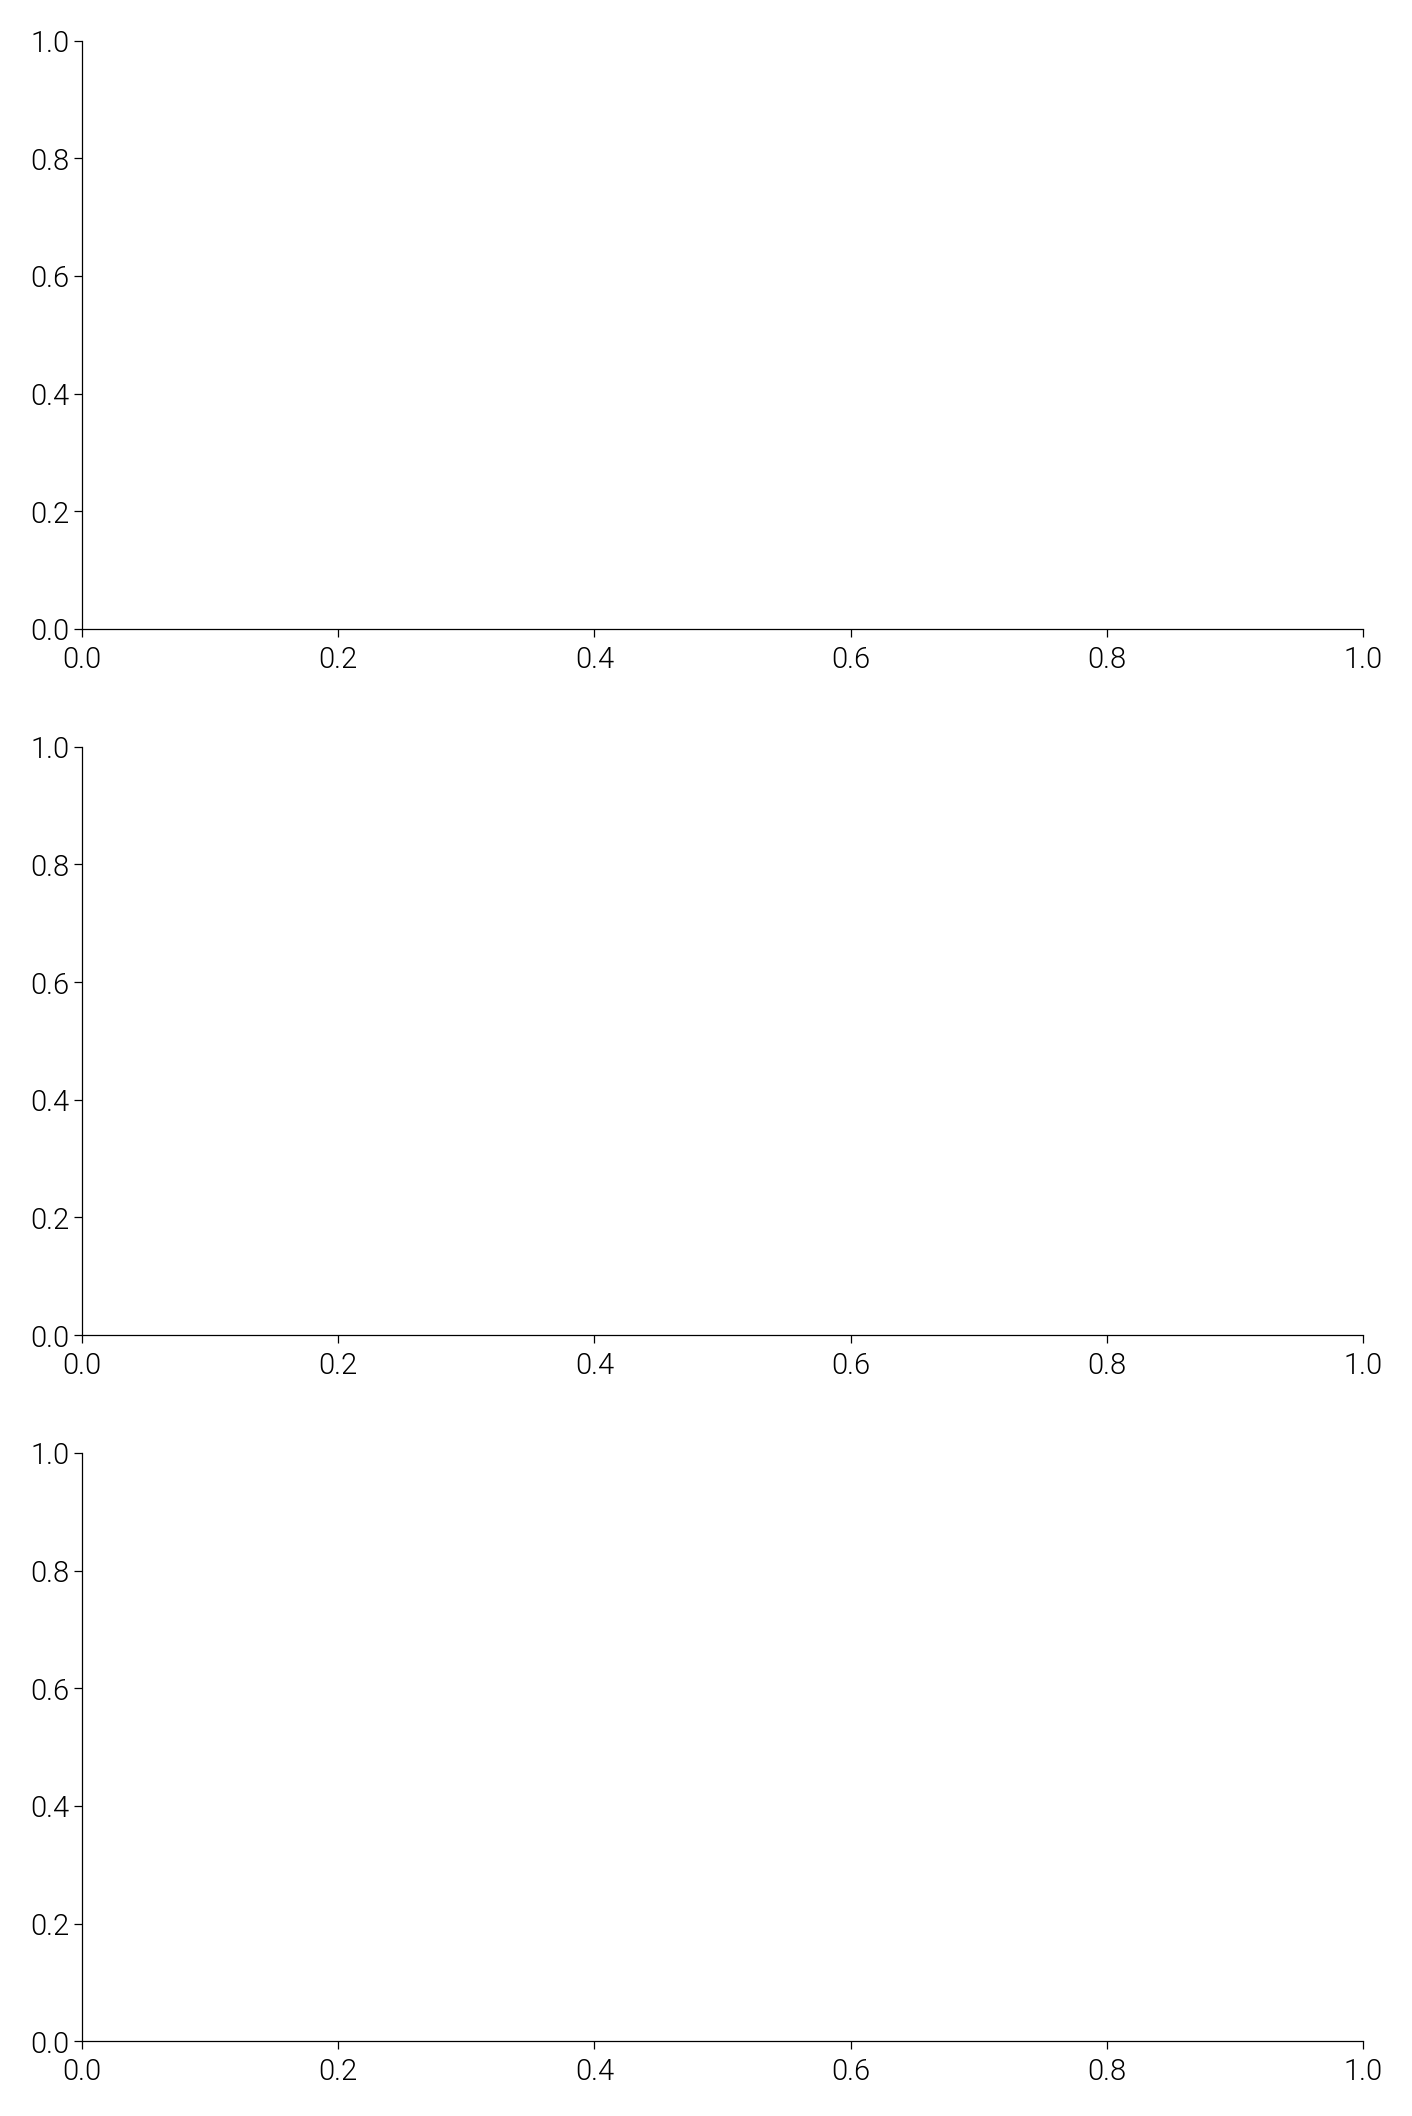

In [12]:
## 5.2 Fan Performance Graphs: Efficiency, Pressure, Power vs Airflow (k_sys 방식)

# 3행(세로) 그래프로 변경, 사이즈도 조절
fig, axes = plt.subplots(3, 1, figsize=(dm.cm2in(14), dm.cm2in(22)))

# Set colors for each k_sys
colors = ['dm.blue5', 'dm.orange5', 'dm.green5', 'dm.red5']

# 1. Efficiency vs Airflow
ax1 = axes[0]
for i, k_sys in enumerate(k_sys_list):
    eff = fan_performance_data['efficiency'][i]
    dV = fan_performance_data['dV_fan']
    mask = ~np.isnan(eff)
    ax1.plot(dV[mask], eff[mask], color=colors[i], linewidth=LW[2], 
             label=f'k_sys = {k_sys} Pa/(m³/s)²')
ax1.set_xlabel('Airflow [m³/s]', fontsize=fs['label'], labelpad=pad['label'])
ax1.set_ylabel('Efficiency [-]', fontsize=fs['label'], labelpad=pad['label'])
ax1.set_title('Fan Efficiency vs Airflow (k_sys method)', fontsize=fs['subtitle'])
ax1.set_ylim(top=1)  # ylim을 1까지 늘림
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=fs['legend'])
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax1.tick_params(axis='both', which='both', labelsize=fs['tick'], pad=pad['tick'])

# 2. Pressure Drop vs Airflow
ax2 = axes[1]
for i, k_sys in enumerate(k_sys_list):
    press = fan_performance_data['pressure'][i]
    dV = fan_performance_data['dV_fan']
    mask = ~np.isnan(press)
    ax2.plot(dV[mask], press[mask], color=colors[i], linewidth=LW[2], 
             label=f'k_sys = {k_sys} Pa/(m³/s)²')
ax2.set_xlabel('Airflow [m³/s]', fontsize=fs['label'], labelpad=pad['label'])
ax2.set_ylabel('Pressure [Pa]', fontsize=fs['label'], labelpad=pad['label'])
ax2.set_title('System Pressure Drop vs Airflow (k_sys method)', fontsize=fs['subtitle'])
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=fs['legend'])
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax2.tick_params(axis='both', which='both', labelsize=fs['tick'], pad=pad['tick'])

# 3. Power vs Airflow
ax3 = axes[2] 
for i, k_sys in enumerate(k_sys_list):
    power = fan_performance_data['power'][i]
    dV = fan_performance_data['dV_fan']
    mask = ~np.isnan(power)
    ax3.plot(dV[mask], power[mask], color=colors[i], linewidth=LW[2], 
             label=f'k_sys = {k_sys} Pa/(m³/s)²')
ax3.set_xlabel('Airflow [m³/s]', fontsize=fs['label'], labelpad=pad['label'])
ax3.set_ylabel('Power [W]', fontsize=fs['label'], labelpad=pad['label'])
ax3.set_title('Fan Power Consumption vs Airflow (k_sys method)', fontsize=fs['subtitle'])
ax3.grid(True, alpha=0.3)
ax3.legend(fontsize=fs['legend'])
ax3.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax3.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax3.tick_params(axis='both', which='both', labelsize=fs['tick'], pad=pad['tick'])

# Adjust layout
plt.tight_layout()
dm.simple_layout(fig, margins=(0.05, 0.05, 0.05, 0.05), bbox=[0, 1, 0.02, 1])

# Save and show
plt.savefig('figure/ASHP/fan_performance_validation_k_sys.png', dpi=300)
dm.save_and_show(fig)
plt.close()

print("Fan performance validation graphs (k_sys method) generated.")


In [19]:
## 5.3 Wang 상관식 적용 버전 계산

# Wang 상관식 파라미터 설정
fin_type = 'louver'  # 핀 형상: 'plain', 'louver', 'wavy'
fin_pitch = 0.002  # 핀 피치 [m] (2mm)
tube_diameter = 0.0095  # 튜브 외경 [m] (9.5mm)
fin_thickness = 0.0001  # 핀 두께 [m] (0.1mm)
louver_angle = 30.0  # 루버 각도 [deg]
tube_rows = 2  # 튜브 열수 [-]

# 열교환기 물리 파라미터 (기존과 동일)
D_h = 0.005  # 수력직경 [m]
L = 0.5  # 유효 길이 [m]
A_cross = 0.5  # 열교환기 단면적 [m²] (기존 A_fan과 동일하게 설정)

# 평균 공기 온도 (Wang 상관식 계산용)
T_air_avg_C = 20.0  # [°C]

# 결과 저장용 딕셔너리 (Wang 상관식)
fan_performance_data_wang = {
    'dV_fan': dV_range,
    'efficiency': [],
    'pressure': [],
    'power': []
}

# Wang 상관식 적용 버전 계산
print("Wang 상관식 적용 버전 계산 중...")
fan_params_wang = {
    'P_max': P_max,
    'dV_max': dV_max,
    'eta_max': eta_max,
    'k_sys': None,  # k_sys를 None으로 설정하여 Wang 상관식 사용
    'A_fan': A_fan,
    'bep_ratio': bep_ratio,
    # Wang 상관식 파라미터
    'fin_type': fin_type,
    'fin_pitch': fin_pitch,
    'tube_diameter': tube_diameter,
    'fin_thickness': fin_thickness,
    'louver_angle': louver_angle,
    'tube_rows': tube_rows,
    # 열교환기 물리 파라미터
    'D_h': D_h,
    'L': L,
    'A_cross': A_cross,
}

# 각 유속에 대해 성능 계산
efficiencies_wang = []
pressures_wang = []
powers_wang = []

for dV in dV_range:
    # _calc_fan_power_from_airflow 메서드 호출
    result = ashp_model._calc_fan_power_from_airflow(dV, fan_params_wang, T_air_avg_C=T_air_avg_C)
    
    if result is not None:
        efficiencies_wang.append(result['operating_efficiency'])
        pressures_wang.append(result['operating_pressure_Pa'])
        powers_wang.append(result['required_power_W'])
    else:
        efficiencies_wang.append(np.nan)
        pressures_wang.append(np.nan)
        powers_wang.append(np.nan)

# 결과 저장
fan_performance_data_wang['efficiency'] = np.array(efficiencies_wang)
fan_performance_data_wang['pressure'] = np.array(pressures_wang)
fan_performance_data_wang['power'] = np.array(powers_wang)

print("Wang 상관식 적용 버전 계산 완료")


Wang 상관식 적용 버전 계산 중...


ValueError: fan_design_flow_rate and fan_design_power must be provided in fan_params

IndexError: list index out of range

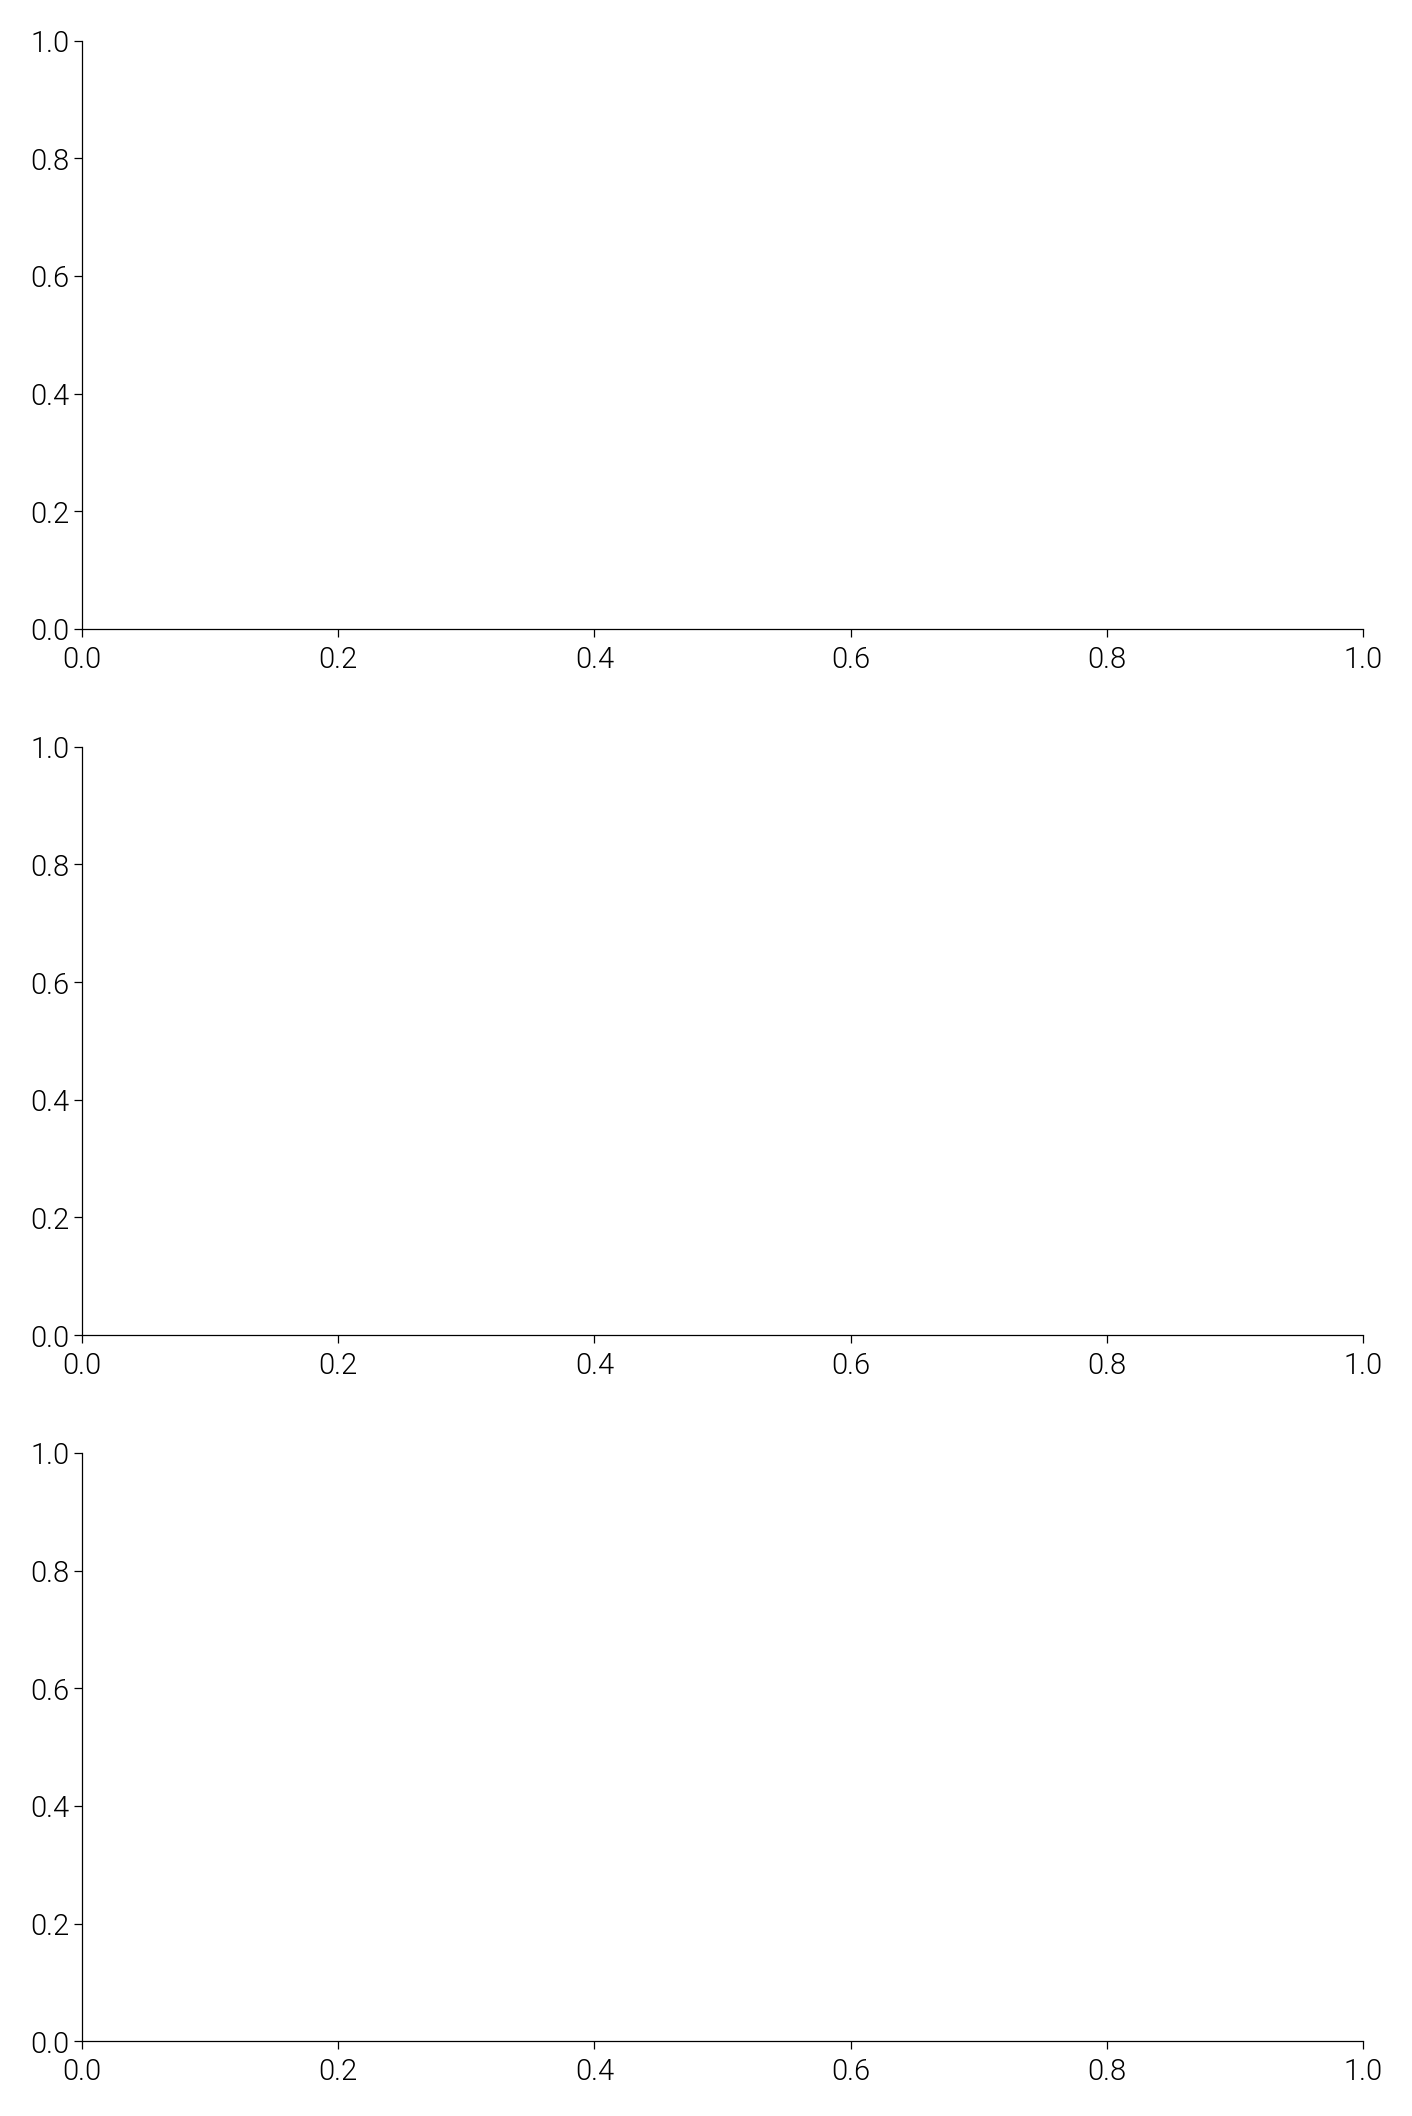

In [20]:
## 5.4 비교 플롯: k_sys 방식 vs Wang 상관식

# 3행(세로) 그래프로 비교 플롯 생성
fig, axes = plt.subplots(3, 1, figsize=(dm.cm2in(14), dm.cm2in(22)))

# Set colors
colors_k_sys = ['dm.blue5', 'dm.orange5', 'dm.green5', 'dm.red5']
color_wang = 'dm.purple5'

# 1. Efficiency vs Airflow
ax1 = axes[0]
# k_sys 방식 플롯
for i, k_sys in enumerate(k_sys_list):
    eff = fan_performance_data['efficiency'][i]
    dV = fan_performance_data['dV_fan']
    mask = ~np.isnan(eff)
    ax1.plot(dV[mask], eff[mask], color=colors_k_sys[i], linewidth=LW[2], 
             linestyle='-', label=f'k_sys = {k_sys} Pa/(m³/s)²', alpha=0.7)
# Wang 상관식 플롯
eff_wang = fan_performance_data_wang['efficiency']
dV = fan_performance_data_wang['dV_fan']
mask = ~np.isnan(eff_wang)
ax1.plot(dV[mask], eff_wang[mask], color=color_wang, linewidth=LW[3], 
         linestyle='--', label='Wang correlation (Louver fin)', alpha=1.0)
ax1.set_xlabel('Airflow [m³/s]', fontsize=fs['label'], labelpad=pad['label'])
ax1.set_ylabel('Efficiency [-]', fontsize=fs['label'], labelpad=pad['label'])
ax1.set_title('Fan Efficiency vs Airflow: k_sys vs Wang Correlation', fontsize=fs['subtitle'])
ax1.set_ylim(top=1)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=fs['legend'])
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax1.tick_params(axis='both', which='both', labelsize=fs['tick'], pad=pad['tick'])

# 2. Pressure Drop vs Airflow
ax2 = axes[1]
# k_sys 방식 플롯
for i, k_sys in enumerate(k_sys_list):
    press = fan_performance_data['pressure'][i]
    dV = fan_performance_data['dV_fan']
    mask = ~np.isnan(press)
    ax2.plot(dV[mask], press[mask], color=colors_k_sys[i], linewidth=LW[2], 
             linestyle='-', label=f'k_sys = {k_sys} Pa/(m³/s)²', alpha=0.7)
# Wang 상관식 플롯
press_wang = fan_performance_data_wang['pressure']
mask = ~np.isnan(press_wang)
ax2.plot(dV[mask], press_wang[mask], color=color_wang, linewidth=LW[3], 
         linestyle='--', label='Wang correlation (Louver fin)', alpha=1.0)
ax2.set_xlabel('Airflow [m³/s]', fontsize=fs['label'], labelpad=pad['label'])
ax2.set_ylabel('Pressure [Pa]', fontsize=fs['label'], labelpad=pad['label'])
ax2.set_title('System Pressure Drop vs Airflow: k_sys vs Wang Correlation', fontsize=fs['subtitle'])
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=fs['legend'])
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax2.tick_params(axis='both', which='both', labelsize=fs['tick'], pad=pad['tick'])

# 3. Power vs Airflow
ax3 = axes[2]
# k_sys 방식 플롯
for i, k_sys in enumerate(k_sys_list):
    power = fan_performance_data['power'][i]
    dV = fan_performance_data['dV_fan']
    mask = ~np.isnan(power)
    ax3.plot(dV[mask], power[mask], color=colors_k_sys[i], linewidth=LW[2], 
             linestyle='-', label=f'k_sys = {k_sys} Pa/(m³/s)²', alpha=0.7)
# Wang 상관식 플롯
power_wang = fan_performance_data_wang['power']
mask = ~np.isnan(power_wang)
ax3.plot(dV[mask], power_wang[mask], color=color_wang, linewidth=LW[3], 
         linestyle='--', label='Wang correlation (Louver fin)', alpha=1.0)
ax3.set_xlabel('Airflow [m³/s]', fontsize=fs['label'], labelpad=pad['label'])
ax3.set_ylabel('Power [W]', fontsize=fs['label'], labelpad=pad['label'])
ax3.set_title('Fan Power Consumption vs Airflow: k_sys vs Wang Correlation', fontsize=fs['subtitle'])
ax3.grid(True, alpha=0.3)
ax3.legend(fontsize=fs['legend'])
ax3.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax3.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax3.tick_params(axis='both', which='both', labelsize=fs['tick'], pad=pad['tick'])

# Adjust layout
plt.tight_layout()
dm.simple_layout(fig, margins=(0.05, 0.05, 0.05, 0.05), bbox=[0, 1, 0.02, 1])

# Save and show
plt.savefig('figure/ASHP/fan_performance_comparison_k_sys_vs_wang.png', dpi=300)
dm.save_and_show(fig)
plt.close()

print("Comparison plots (k_sys vs Wang correlation) generated.")


# 6. 변풍량 팬 성능 분석

ASHRAE 90.1 VSD Curve 모델을 사용한 변풍량 팬의 성능을 다양한 설계 파라미터 조합으로 분석합니다.


## 6.1 직접 팬 성능 테스트 (VSD Curve 검증)

다양한 설계 파라미터 조합에서 풍량에 따른 Part-load ratio와 팬 전력을 계산합니다.


In [31]:
# 직접 팬 성능 테스트: VSD Curve 검증
# 다양한 설계 파라미터 조합 테스트

# 테스트 파라미터 범위
fan_design_flow_rates = [1.5, 2.0, 2.5, 3.0]  # m³/s
fan_design_pressures = [300, 400, 500, 600]    # Pa
fan_total_efficiency = 0.55  # 고정값

# ASHRAE 90.1 VSD Curve 계수
c1, c2, c3, c4, c5 = 0.04076, 0.08804, -0.07293, 0.94374, 0.0
c1, c2, c3, c4, c5 = 0.0013, 0.1470, 0.9506, -0.0998, 0.0
# 결과 저장용 딕셔너리
direct_fan_test_results = []

# 각 설계 파라미터 조합에 대해 테스트
fan_design_power = 1000
for fan_design_flow_rate in fan_design_flow_rates:
    for fan_design_pressure in fan_design_pressures:
        # 설계 전력 계산: P_design = (V_design * ΔP_design) / η_tot
        
        # 풍량 범위 설정: 0.1 ~ 설계 풍량의 1.2배
        dV_range = np.linspace(0.1, fan_design_flow_rate * 1.0, 200)
        
        # 각 풍량에 대해 계산
        flow_fractions = []
        pl_ratios = []
        fan_powers = []
        
        for dV_fan in dV_range:
            # Flow fraction 계산
            flow_fraction = dV_fan / fan_design_flow_rate
            
            # Part-load ratio 계산: pl_ratio = c1 + c2*x + c3*x² + c4*x³ + c5*x⁴
            x = flow_fraction
            pl_ratio = c1 + c2*x + c3*x**2 + c4*x**3 + c5*x**4
            pl_ratio = max(0.0, pl_ratio)  # 음수 방지
            
            # 팬 전력 계산
            fan_power = fan_design_power * pl_ratio
            
            flow_fractions.append(flow_fraction)
            pl_ratios.append(pl_ratio)
            fan_powers.append(fan_power)
        
        # 결과 저장
        direct_fan_test_results.append({
            'fan_design_flow_rate': fan_design_flow_rate,
            'fan_design_pressure': fan_design_pressure,
            'fan_design_power': fan_design_power,
            'fan_total_efficiency': fan_total_efficiency,
            'dV_range': dV_range,
            'flow_fractions': np.array(flow_fractions),
            'pl_ratios': np.array(pl_ratios),
            'fan_powers': np.array(fan_powers),
            'fan_powers_normalized': np.array(fan_powers) / fan_design_power  # 정규화된 전력
        })

print(f"직접 팬 성능 테스트 완료: {len(direct_fan_test_results)} 개 조합")


직접 팬 성능 테스트 완료: 16 개 조합


## 6.2 직접 팬 성능 테스트 그래프


In [34]:
# 팬 설계 유량이 2.0 m³/s인 경우의 팬 효율(η)과 팬 Power를, 압력차 별로 twin axis 그래프로(동일 압력은 동일 색, 효율-solid, 파워-dashed) 출력

import matplotlib.ticker as ticker

# 팬 효율 계산 함수 (total efficiency 기준)  
def calc_fan_efficiency(result):
    # η = (풍량 * 압력차) / (Power * 1000)   단위: m³/s * Pa / (W * 1000) → 무차원
    # 또는: 효율 = 풍량 * 압력차 / (파워 * 1000)
    dV = result['dV_range']               # m³/s
    dP = result['fan_design_pressure']    # Pa (design값, 고정)
    P = result['fan_powers']              # W
    with np.errstate(divide='ignore', invalid='ignore'):
        eff = dV * dP / (np.array(P))
        eff[P <= 0] = np.nan
    return eff

fig, ax1 = plt.subplots(figsize=(dm.cm2in(16), dm.cm2in(7)))

colors_pressure = ['dm.blue5', 'dm.orange5', 'dm.green5', 'dm.red5', 'dm.purple5']

pressure_list = []
for result in direct_fan_test_results:
    if np.isclose(result['fan_design_flow_rate'], 2.0):
        pressure_list.append(result['fan_design_pressure'])
pressure_list = sorted(list(set(pressure_list)))

lines_eff = []
lines_power = []

for i, dp in enumerate(pressure_list):
    for result in direct_fan_test_results:
        if np.isclose(result['fan_design_flow_rate'], 2.0) and result['fan_design_pressure'] == dp:
            flow_frac = result['flow_fractions']
            fan_power = result['fan_powers']
            fan_eff   = calc_fan_efficiency(result)

            # 효율 (solid)
            line1, = ax1.plot(flow_frac, fan_eff, 
                     color=colors_pressure[i % len(colors_pressure)], 
                     linestyle='-', linewidth=LW[2],
                     label=f"Eff.: ΔP={dp:.0f} Pa")
            lines_eff.append(line1)

            # fan power (dashed) - twin axis
            if i == 0:
                ax2 = ax1.twinx()
            line2, = ax2.plot(flow_frac, fan_power, 
                     color=colors_pressure[i % len(colors_pressure)], 
                     linestyle='--', linewidth=LW[2],
                     label=f"Power: ΔP={dp:.0f} Pa")
            lines_power.append(line2)
            break

ax1.set_xlabel('Flow fraction [-]', fontsize=fs['label'], labelpad=pad['label'])
ax1.set_ylabel('Fan Efficiency [-]', fontsize=fs['label'], labelpad=pad['label'])
ax2.set_ylabel('Fan Power [W]', fontsize=fs['label'], labelpad=pad['label'])

ax1.grid(True, alpha=0.3)
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax1.tick_params(axis='both', which='both', labelsize=fs['tick'], pad=pad['tick'])
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax2.tick_params(axis='both', which='both', labelsize=fs['tick'], pad=pad['tick'])

# 범례 custom
from matplotlib.legend_handler import HandlerTuple
# 효율과 파워를 압력차별로 묶어서 표시
legend_handles = []
legend_labels = []
for i, dp in enumerate(pressure_list):
    tup = (lines_eff[i], lines_power[i])
    legend_handles.append(tup)
    legend_labels.append(f"ΔP_design={dp:.0f} Pa")

ax1.legend(legend_handles, legend_labels, fontsize=fs['legend'], loc='upper left')

plt.tight_layout()
dm.simple_layout(fig, margins=(0.05, 0.05, 0.05, 0.05), bbox=[0, 1, 0.02, 1])
plt.savefig('figure/ASHP/vsd_fan_2m3s_eff_power_by_dp.png', dpi=300)
dm.save_and_show(fig)
plt.close()

print("팬 효율 및 파워 twin 그래프(유량 2.0 m³/s, 압력차 별) 생성 완료")


팬 효율 및 파워 twin 그래프(유량 2.0 m³/s, 압력차 별) 생성 완료


array([5.44759976, 5.39319619, 5.33135671, 5.26449345, 5.19435001,
       5.12220156, 5.04898878, 4.97540967, 4.90198374, 4.82909767,
       4.75703826, 4.68601669, 4.61618636, 4.54765637, 4.48050166,
       4.41477078, 4.35049185, 4.28767716, 4.2263268 , 4.16643142,
       4.10797446, 4.05093389, 3.99528357, 3.94099438, 3.88803502,
       3.83637273, 3.78597385, 3.73680421, 3.6888295 , 3.64201552,
       3.59632838, 3.55173469, 3.50820167, 3.46569722, 3.42419004,
       3.38364961, 3.3440463 , 3.30535131, 3.26753674, 3.23057557,
       3.19444165, 3.15910969, 3.12455527, 3.09075477, 3.05768542,
       3.02532521, 2.99365291, 2.96264805, 2.93229087, 2.9025623 ,
       2.87344395, 2.8449181 , 2.81696763, 2.78957603, 2.76272739,
       2.73640634, 2.71059805, 2.68528823, 2.66046305, 2.6361092 ,
       2.61221381, 2.58876444, 2.5657491 , 2.54315619, 2.52097451,
       2.49919324, 2.47780192, 2.45679043, 2.436149  , 2.41586817,
       2.3959388 , 2.37635203, 2.35709931, 2.33817234, 2.31956

## 6.3 실제 ASHP 시뮬레이션 테스트

고정된 온도 조건에서 다양한 부하에 대해 최적화를 수행하여 실제 팬 유량과 Part-load ratio를 계산합니다.


In [16]:
# 실제 ASHP 시뮬레이션 테스트
# 다양한 부하 조건에서 팬 성능 관찰

# 테스트 조건
Q_iu_load_range = [1000, 2000, 3000, 4000, 5000]  # W (난방 모드)
T_ia = 22.0  # °C (고정)
T_oa = 5.0   # °C (고정)

# 팬 설계 파라미터 조합 (Case별)
test_cases = [
    {'name': 'Case 1', 'fan_design_flow_rate': 2.0, 'fan_design_pressure': 500},
    {'name': 'Case 2', 'fan_design_flow_rate': 2.5, 'fan_design_pressure': 500},
    {'name': 'Case 3', 'fan_design_flow_rate': 2.0, 'fan_design_pressure': 400},
]

fan_total_efficiency = 0.55  # 고정값

# 결과 저장용 리스트
ashp_simulation_results = []

# 각 테스트 케이스에 대해 시뮬레이션 수행
for case in test_cases:
    print(f"\n{case['name']} 시뮬레이션 중...")
    print(f"  설계 파라미터: V_design={case['fan_design_flow_rate']:.1f} m³/s, ΔP_design={case['fan_design_pressure']:.0f} Pa")
    
    # ASHP 모델 생성 (팬 파라미터 설정)
    ashp_test = dem.AirSourceHeatPump(
        V_disp_cmp=0.0005,
        eta_cmp_isen=0.7,
        eta_cmp_vol=0.85,
        A_iu=15.0,
        A_ou=20.0,
        U_coeff_iu=100.0,
        U_coeff_ou=80.0,
        fan_design_flow_rate_iu=case['fan_design_flow_rate'],
        fan_design_pressure_iu=case['fan_design_pressure'],
        fan_total_efficiency_iu=fan_total_efficiency,
        motor_in_air_fraction_iu=1.0,
        T0_K=293.15
    )
    
    # 설계 전력 계산
    fan_design_power = (case['fan_design_flow_rate'] * case['fan_design_pressure']) / fan_total_efficiency
    
    # 각 부하에 대해 최적화 수행
    case_results = []
    for Q_iu_load in Q_iu_load_range:
        result = ashp_test.find_optimal_operation(
            Q_iu_load=Q_iu_load,
            T_ia=T_ia,
            T_oa=T_oa
        )
        
        if result is not None and result.get('is_on', False):
            dV_iu_fan = result.get('dV_iu_fan', np.nan)
            E_iu_fan = result.get('E_iu_fan', np.nan)
            
            # Flow fraction 계산
            flow_fraction = dV_iu_fan / case['fan_design_flow_rate'] if case['fan_design_flow_rate'] > 0 else np.nan
            
            # Part-load ratio 계산 (실제 전력 / 설계 전력)
            pl_ratio = E_iu_fan / fan_design_power if fan_design_power > 0 else np.nan
            
            case_results.append({
                'Q_iu_load': Q_iu_load,
                'dV_iu_fan': dV_iu_fan,
                'E_iu_fan': E_iu_fan,
                'flow_fraction': flow_fraction,
                'pl_ratio': pl_ratio,
                'E_cmp': result.get('E_cmp', np.nan),
                'E_tot': result.get('E_tot', np.nan),
                'cop': result.get('cop', np.nan),
            })
        else:
            case_results.append({
                'Q_iu_load': Q_iu_load,
                'dV_iu_fan': np.nan,
                'E_iu_fan': np.nan,
                'flow_fraction': np.nan,
                'pl_ratio': np.nan,
                'E_cmp': np.nan,
                'E_tot': np.nan,
                'cop': np.nan,
            })
    
    ashp_simulation_results.append({
        'case_name': case['name'],
        'fan_design_flow_rate': case['fan_design_flow_rate'],
        'fan_design_pressure': case['fan_design_pressure'],
        'fan_design_power': fan_design_power,
        'results': case_results
    })

print(f"\n실제 ASHP 시뮬레이션 테스트 완료: {len(ashp_simulation_results)} 개 케이스")



Case 1 시뮬레이션 중...
  설계 파라미터: V_design=2.0 m³/s, ΔP_design=500 Pa


AttributeError: 'AirSourceHeatPump' object has no attribute 'D_h_iu'

## 6.4 실제 ASHP 시뮬레이션 결과 그래프


In [17]:
# 실제 ASHP 시뮬레이션 결과 그래프

# 그래프 1: Flow fraction vs Q_iu_load
fig, axes = plt.subplots(2, 2, figsize=(dm.cm2in(16), dm.cm2in(12)))

colors_case = ['dm.blue5', 'dm.orange5', 'dm.green5']

# 1-1. Flow fraction vs Q_iu_load
ax1 = axes[0, 0]
for i, case_result in enumerate(ashp_simulation_results):
    Q_loads = [r['Q_iu_load'] for r in case_result['results']]
    flow_fractions = [r['flow_fraction'] for r in case_result['results']]
    
    # NaN 제거
    valid_data = [(q, f) for q, f in zip(Q_loads, flow_fractions) if not np.isnan(f)]
    if valid_data:
        Q_valid, ff_valid = zip(*valid_data)
        ax1.plot(Q_valid, ff_valid, 
                color=colors_case[i], 
                linewidth=LW[2],
                marker='o',
                markersize=4,
                label=f"{case_result['case_name']}\n(V={case_result['fan_design_flow_rate']:.1f}, ΔP={case_result['fan_design_pressure']:.0f})")
ax1.set_xlabel('Heating Load [W]', fontsize=fs['label'], labelpad=pad['label'])
ax1.set_ylabel('Flow Fraction [-]', fontsize=fs['label'], labelpad=pad['label'])
ax1.set_title('Flow Fraction vs Heating Load', fontsize=fs['subtitle'])
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=fs['legend'])
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax1.tick_params(axis='both', which='both', labelsize=fs['tick'], pad=pad['tick'])

# 1-2. Part-load ratio vs Q_iu_load
ax2 = axes[0, 1]
for i, case_result in enumerate(ashp_simulation_results):
    Q_loads = [r['Q_iu_load'] for r in case_result['results']]
    pl_ratios = [r['pl_ratio'] for r in case_result['results']]
    
    valid_data = [(q, p) for q, p in zip(Q_loads, pl_ratios) if not np.isnan(p)]
    if valid_data:
        Q_valid, pl_valid = zip(*valid_data)
        ax2.plot(Q_valid, pl_valid, 
                color=colors_case[i], 
                linewidth=LW[2],
                marker='o',
                markersize=4,
                label=f"{case_result['case_name']}")
ax2.set_xlabel('Heating Load [W]', fontsize=fs['label'], labelpad=pad['label'])
ax2.set_ylabel('Part-load Ratio [-]', fontsize=fs['label'], labelpad=pad['label'])
ax2.set_title('Part-load Ratio vs Heating Load', fontsize=fs['subtitle'])
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=fs['legend'])
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax2.tick_params(axis='both', which='both', labelsize=fs['tick'], pad=pad['tick'])

# 1-3. Fan Power vs Q_iu_load
ax3 = axes[1, 0]
for i, case_result in enumerate(ashp_simulation_results):
    Q_loads = [r['Q_iu_load'] for r in case_result['results']]
    fan_powers = [r['E_iu_fan'] for r in case_result['results']]
    
    valid_data = [(q, p) for q, p in zip(Q_loads, fan_powers) if not np.isnan(p)]
    if valid_data:
        Q_valid, fp_valid = zip(*valid_data)
        ax3.plot(Q_valid, fp_valid, 
                color=colors_case[i], 
                linewidth=LW[2],
                marker='o',
                markersize=4,
                label=f"{case_result['case_name']}")
ax3.set_xlabel('Heating Load [W]', fontsize=fs['label'], labelpad=pad['label'])
ax3.set_ylabel('Fan Power [W]', fontsize=fs['label'], labelpad=pad['label'])
ax3.set_title('Fan Power vs Heating Load', fontsize=fs['subtitle'])
ax3.grid(True, alpha=0.3)
ax3.legend(fontsize=fs['legend'])
ax3.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax3.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax3.tick_params(axis='both', which='both', labelsize=fs['tick'], pad=pad['tick'])

# 1-4. COP vs Q_iu_load
ax4 = axes[1, 1]
for i, case_result in enumerate(ashp_simulation_results):
    Q_loads = [r['Q_iu_load'] for r in case_result['results']]
    cops = [r['cop'] for r in case_result['results']]
    
    valid_data = [(q, c) for q, c in zip(Q_loads, cops) if not np.isnan(c) and c > 0]
    if valid_data:
        Q_valid, cop_valid = zip(*valid_data)
        ax4.plot(Q_valid, cop_valid, 
                color=colors_case[i], 
                linewidth=LW[2],
                marker='o',
                markersize=4,
                label=f"{case_result['case_name']}")
ax4.set_xlabel('Heating Load [W]', fontsize=fs['label'], labelpad=pad['label'])
ax4.set_ylabel('COP [-]', fontsize=fs['label'], labelpad=pad['label'])
ax4.set_title('COP vs Heating Load', fontsize=fs['subtitle'])
ax4.grid(True, alpha=0.3)
ax4.legend(fontsize=fs['legend'])
ax4.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax4.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax4.tick_params(axis='both', which='both', labelsize=fs['tick'], pad=pad['tick'])

plt.tight_layout()
dm.simple_layout(fig, margins=(0.05, 0.05, 0.05, 0.05), bbox=[0, 1, 0.02, 1])
plt.savefig('figure/ASHP/vsd_fan_ashp_simulation.png', dpi=300)
dm.save_and_show(fig)
plt.close()

print("실제 ASHP 시뮬레이션 결과 그래프 생성 완료")


/tmp/ipykernel_687358/4241674898.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=fs['legend'])
/tmp/ipykernel_687358/4241674898.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(fontsize=fs['legend'])
/tmp/ipykernel_687358/4241674898.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend(fontsize=fs['legend'])
/tmp/ipykernel_687358/4241674898.py:100: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax4.legend(fontsize=fs['legend'])


실제 ASHP 시뮬레이션 결과 그래프 생성 완료


## 6.5 VSD Curve 물리적 정합성 검증

직접 계산한 Part-load ratio와 실제 시뮬레이션 결과를 비교하여 VSD Curve 모델의 정합성을 검증합니다.


IndexError: list index out of range

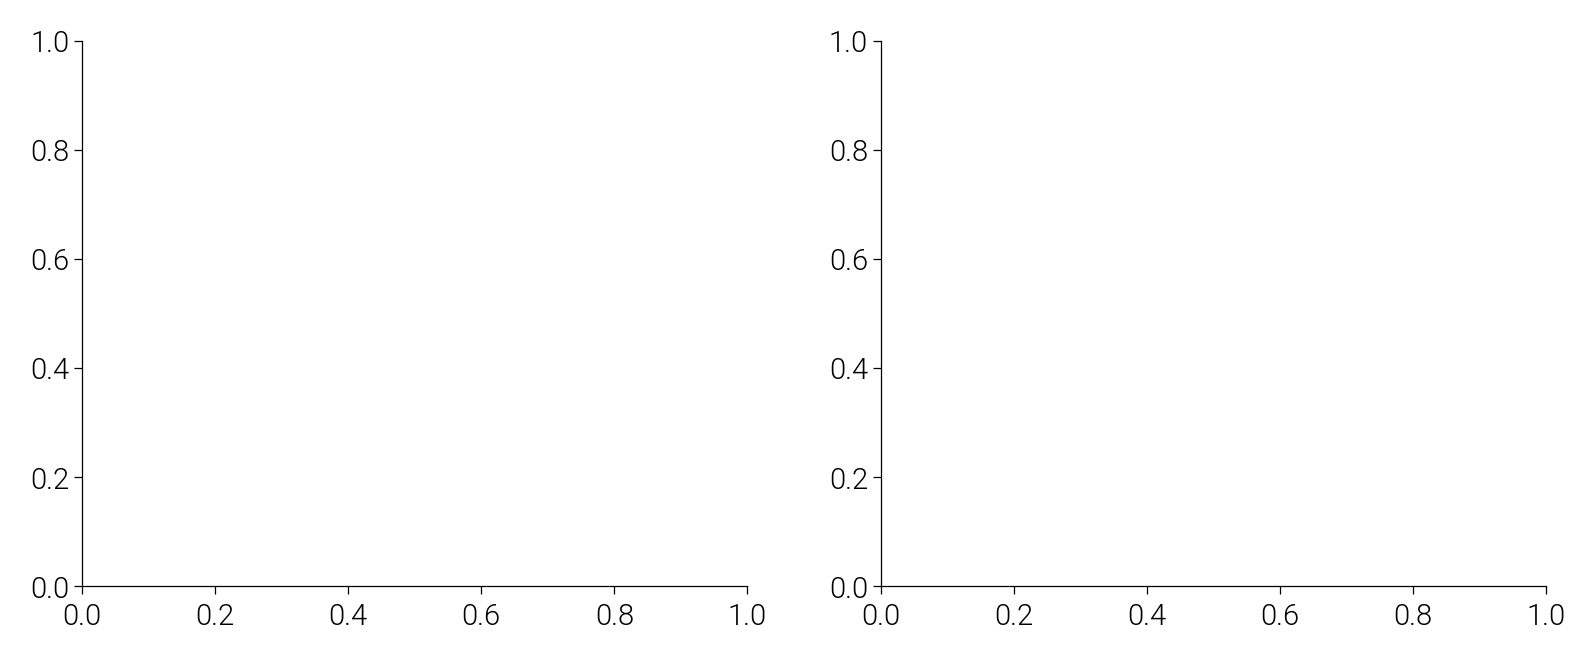

In [18]:
# VSD Curve 물리적 정합성 검증
# 직접 계산한 Part-load ratio와 실제 시뮬레이션 결과 비교

fig, axes = plt.subplots(1, 2, figsize=(dm.cm2in(16), dm.cm2in(6)))

# Case 1 (V_design=2.0, ΔP=500)에 대해 비교
case_to_compare = ashp_simulation_results[0]  # Case 1
direct_result = None
for r in direct_fan_test_results:
    if r['fan_design_flow_rate'] == 2.0 and r['fan_design_pressure'] == 500:
        direct_result = r
        break

if direct_result is not None:
    # 왼쪽 그래프: Flow fraction vs Part-load ratio (직접 계산 vs 이론)
    ax1 = axes[0]
    
    # 이론 VSD Curve (직접 계산)
    ax1.plot(direct_result['flow_fractions'], direct_result['pl_ratios'], 
            color='dm.blue5', linewidth=LW[3], linestyle='-',
            label='VSD Curve (Theoretical)', alpha=0.8)
    
    # 실제 시뮬레이션 결과
    Q_loads = [r['Q_iu_load'] for r in case_to_compare['results']]
    flow_fractions_sim = [r['flow_fraction'] for r in case_to_compare['results']]
    pl_ratios_sim = [r['pl_ratio'] for r in case_to_compare['results']]
    
    valid_data = [(ff, pl) for ff, pl in zip(flow_fractions_sim, pl_ratios_sim) 
                  if not np.isnan(ff) and not np.isnan(pl)]
    if valid_data:
        ff_valid, pl_valid = zip(*valid_data)
        ax1.scatter(ff_valid, pl_valid, 
                   color='dm.red5', s=50, alpha=0.7,
                   label='ASHP Simulation', zorder=5)
    
    ax1.set_xlabel('Flow Fraction [-]', fontsize=fs['label'], labelpad=pad['label'])
    ax1.set_ylabel('Part-load Ratio [-]', fontsize=fs['label'], labelpad=pad['label'])
    ax1.set_title('VSD Curve Validation\n(Case 1: V=2.0 m³/s, ΔP=500 Pa)', fontsize=fs['subtitle'])
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=fs['legend'])
    ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax1.tick_params(axis='both', which='both', labelsize=fs['tick'], pad=pad['tick'])
    
    # 오른쪽 그래프: Flow fraction vs Normalized Power
    ax2 = axes[1]
    
    # 이론 VSD Curve
    ax2.plot(direct_result['flow_fractions'], direct_result['fan_powers_normalized'], 
            color='dm.blue5', linewidth=LW[3], linestyle='-',
            label='VSD Curve (Theoretical)', alpha=0.8)
    
    # 실제 시뮬레이션 결과 (정규화)
    normalized_powers_sim = [r['E_iu_fan'] / case_to_compare['fan_design_power'] 
                            for r in case_to_compare['results']]
    
    valid_data = [(ff, np) for ff, np in zip(flow_fractions_sim, normalized_powers_sim) 
                  if not np.isnan(ff) and not np.isnan(np)]
    if valid_data:
        ff_valid, np_valid = zip(*valid_data)
        ax2.scatter(ff_valid, np_valid, 
                   color='dm.red5', s=50, alpha=0.7,
                   label='ASHP Simulation', zorder=5)
    
    ax2.set_xlabel('Flow Fraction [-]', fontsize=fs['label'], labelpad=pad['label'])
    ax2.set_ylabel('Normalized Fan Power [-]', fontsize=fs['label'], labelpad=pad['label'])
    ax2.set_title('Normalized Power Validation\n(Case 1: V=2.0 m³/s, ΔP=500 Pa)', fontsize=fs['subtitle'])
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=fs['legend'])
    ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax2.tick_params(axis='both', which='both', labelsize=fs['tick'], pad=pad['tick'])

plt.tight_layout()
dm.simple_layout(fig, margins=(0.05, 0.05, 0.05, 0.05), bbox=[0, 1, 0.02, 1])
plt.savefig('figure/ASHP/vsd_fan_validation.png', dpi=300)
dm.save_and_show(fig)
plt.close()

print("VSD Curve 물리적 정합성 검증 그래프 생성 완료")
